In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import regularizers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [27]:
csvFilePath = './data/stocks2023/hbl_feat.csv'
df = pd.read_csv(csvFilePath)

In [29]:
# Extract all columns as features for the LSTM model
features = df.drop(['Date', 'Close'], axis=1).values
target = df['Close'].values

# Normalize the features and target
scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

# Function to create the dataset with time steps
def createDataset(dataset, target, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(target[i + look_back])
    return np.array(dataX), np.array(dataY)

# Set the number of time steps (look back)
lookBack = 3

# Create the dataset with time steps
X, y = createDataset(featuresScaled, targetScaled, lookBack)

# Split the data into training and testing sets
trainSize = int(len(X) * 0.8)
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))


In [30]:
batchSize = 1
epoch = 10
neurons = 50
dropout = 0.2

# model = Sequential()
# model.add(LSTM(50, input_shape=(lookBack, features.shape[1])))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(units=1, activation='linear', activity_regularizer=regularizers.l1(0.00001)))
model.add(Activation('tanh'))

model.compile(loss='mean_squared_error' , optimizer='RMSprop')

# Train the model
model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.2)

Epoch 1/10
1291/1291 [==============================] - 5s 2ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 2/10
1291/1291 [==============================] - 2s 2ms/step - loss: 0.0022 - val_loss: 1.7763e-04
Epoch 3/10
1291/1291 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 1.7533e-04
Epoch 4/10
1291/1291 [==============================] - 2s 2ms/step - loss: 0.0018 - val_loss: 2.4787e-04
Epoch 5/10
1291/1291 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 1.5705e-04
Epoch 6/10
1291/1291 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 7.3785e-04
Epoch 7/10
1291/1291 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 2.7873e-04
Epoch 8/10
1291/1291 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 1.3983e-04
Epoch 9/10
1291/1291 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 7.1400e-04
Epoch 10/10
1291/1291 [===========================

13/13 [==============================] - 0s 926us/step
Training RMSE: 5.357985725376
Testing RMSE: 4.0755688219459065


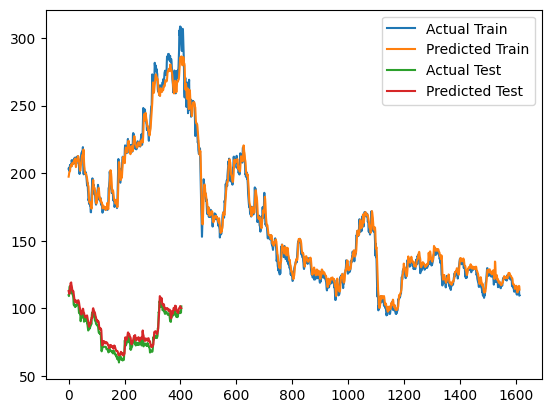

In [31]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale
trainPredict = scalerTarget.inverse_transform(trainPredict)
trainY = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredict = scalerTarget.inverse_transform(testPredict)
testY = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:, 0], trainPredict[:, 0]))
print(f'Training RMSE: {trainScore}')
testScore = np.sqrt(mean_squared_error(testY[:, 0], testPredict[:, 0]))
print(f'Testing RMSE: {testScore}')

# Plot the results
plt.plot(trainY, label='Actual Train')
plt.plot(trainPredict, label='Predicted Train')
plt.plot(testY, label='Actual Test')
plt.plot(testPredict, label='Predicted Test')
plt.legend()
plt.show()